In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'build_corpus'

In [ ]:
df = pd.read_csv('../data/lck_dockstring_data1.csv')
print(df.head())

: 

In [ ]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qed'].values.reshape(-1,1))
logp_scaler.fit(df['logp'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsa'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qed'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logp'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsa'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

: 

In [ ]:
# train_len = int(0.8*len(df))
# test_len = len(df) - train_len
# split_labels = np.array(['train'] * train_len + ['test'] * test_len)
# np.random.shuffle(split_labels)

: 

In [ ]:
# df['split'] = split_labels

: 

In [ ]:
SMI_MAX_SIZE= 254
# with open('../data/smiles_corpus.txt', 'w') as f:
#     train = []
#     test = []        
#     for i, row in df.iterrows():
#         if row['split'] == "test":
#             test.append(list(row.values))
#         else:
#             train.append(list(row.values))
#         f.write(split(row['smiles'] +'\n'))
        
#         if SMI_MAX_SIZE < len(row['smiles']):
#             SMI_MAX_SIZE = len(row['smiles'])
# f.close()
# print("SMI_MAX_SIZE ", SMI_MAX_SIZE, flush=True)
# train_df = pd.DataFrame(train, columns=df.columns)
# test_df = pd.DataFrame(test, columns=df.columns)
# with open('../data/train_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(train_df, f)
# with open('../data/test_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(test_df, f)
with open('../data/train_df_with_sas.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('../data/test_df_with_sas.pkl', 'rb') as f:
    test_df = pickle.load(f)

: 

In [ ]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

: 

In [ ]:
# class CustomTargetDataset(Dataset):
#     def __init__(self, dataframe, SmilesVocab, properties_list):
#         self.dataframe = dataframe
#         self.smiles_vocab = SmilesVocab
#         self.property_list = properties_list
#         self.build()
        
#     def build(self):
#         smiles, properties, affinities= [],[],[]
#         smiles_encoding = []
#         for i, row in self.dataframe.iterrows():
#             smi = row['smiles']
#             # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
#             newsmi = smi
#             smiles.append(newsmi)
#             smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
#             props = []
#             for p in self.property_list:
#                 props.append(row[p])
#             properties.append(props)

#         self.smiles_encodings = torch.tensor(smiles_encoding)
#         self.properties = torch.tensor(properties)
#         self.smiles = smiles
#         # self.affinities = torch.tensor(affinities)
#         print("dataset built")
        
#     def __len__(self):
#         return len(self.properties)
    
#     def __getitem__(self, index):
#         return {
#             "smiles_rep": self.smiles_encodings[index],
#             "properties": self.properties[index],
#             "smiles":self.smiles[index]
#         }

class CustomTargetDataset(Dataset):
    def __init__(self, df, vocab, properties_list):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.props = properties_list    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row['smiles']
        seq = self.vocab.to_seq(split(smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True)
        prop_vals = [row[p] for p in self.props]
        return {
            "smiles_rep": torch.tensor(seq, dtype=torch.long),
            "properties": torch.tensor(prop_vals, dtype=torch.float32),
            "smiles": smi
        }

: 

In [ ]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

: 

In [ ]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

: 

In [ ]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

: 

In [ ]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))

        # Property side: per-property projection + encoder
        self.property_encoder = PropertyEncoder(d_model, n_properties=n_properties)
        self.prop_pe = PositionalEncodings(n_properties, d_model, dropout)
        self.prop_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=hidden_units,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.prop_encoder = nn.TransformerEncoder(
            encoder_layer=self.prop_enc_layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        
    def forward(self, x, property):
        # Encode properties -> contextual memory
        prop_feats = self.property_encoder(property)          # (B, P, D)
        prop_feats = self.prop_pe(prop_feats)                 # (B, P, D)
        memory = self.prop_encoder(prop_feats)                # (B, P, D)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=memory,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

: 

In [ ]:
# import nn.utils.clip_grad_value_
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(tqdm(data_loader)):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)

: 

In [ ]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)

: 

In [ ]:
class Sampler:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property)
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples

: 

In [ ]:
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

: 

In [ ]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


def run(config):
    PROPERTIES = config['properties']
    train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=PROPERTIES)
    test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=PROPERTIES)
    train_SMILES = train_df['smiles'].tolist()

    batch_size = config['batch_size'] # Define your batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    data = next(iter(train_loader))
 
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(PROPERTIES), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    model = torch.nn.parallel.DataParallel(model)
    path_dir = '../checkpoints/'+ config['run_name'] + '/model.pt'
    model.load_state_dict(torch.load("/home2/bhuvan.kapur/MolGPT2.0/checkpoints/LCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas/model.pt",weights_only=True,map_location=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    
    
    tl = []
    vl = []
    

    wandb.init(project="molgpt2.0 FINAL", config=config, name=config['run_name'])
    wandb.watch(models=model, log_freq=100)
    print(config)

    sampler = Sampler(model, smiles_vocab)
    All_samples = []
    for i in (range(config['epochs'])):
        
        train_loss = train_step(model, train_loader, optimizer,i)
        val_loss = val_step(model, test_loader, i)
        tl.append(train_loss)
        vl.append(val_loss)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)
        save_model(model, config)
        
        if i % 3 == 0 and i!=0:
            properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, test_loader, greedy=False)
            results = compute_metrics(train_SMILES, test_SMILES, pred_SMILES)
            for key in results:
                print(f"{key}: {results[key]}")
            df = pd.DataFrame({"SMILES":pred_SMILES})
            df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')

: 

In [ ]:
# columns = ['smiles', 'affinity', 'logps', 'qeds', 'tpsas', 'split']
config = {
    'batch_size' : 256,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 512,
    'lr': 1e-5,
    'epochs': 10,
    'properties': sorted(['affinity', 'logps', 'qeds', 'tpsas', 'sas']),
}
config['run_name'] = "LCK_DOCKSTRING_FAST_ACTUAL_"+ "_".join(prop for prop in config['properties'])
print(config)

: 

In [ ]:
# run(config)

: 

In [ ]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

: 

In [ ]:
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=2)

: 

In [ ]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

: 

In [ ]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

: 

In [ ]:
print(config)

: 

In [ ]:
model = load_model(config)

: 

In [ ]:
properties, samples, og_smiles = sample_a_bunch(model, test_loader, greedy=False)
train_SMILES = train_df['smiles'].tolist()
compute_metrics(train_SMILES, og_smiles, samples)

: 

In [ ]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, samples)

: 

In [ ]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_qeds = og_props[:,2]
og_sas = og_props[:,3]
og_tpsa = og_props[:,4]

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

: 

In [ ]:
stats = pd.DataFrame({
                      "SAS_pred":sas, 
                      "QED_pred":qeds, 
                      "LogP_pred":logps, 
                    #   "molwt_pred":molwt, 
                      "TPSA_pred":tpsas})
stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
stats['QED_og'] = qed_scaler.inverse_transform(og_qeds.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

: 

In [ ]:
import seaborn as sns
sns.pairplot(stats)

: 

Restarted Python 3.10.12

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'build_corpus'

In [ ]:
df = pd.read_csv('../data/lck_dockstring_data1.csv')
print(df.head())

: 

In [ ]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qed'].values.reshape(-1,1))
logp_scaler.fit(df['logp'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsa'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qed'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logp'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsa'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

: 

In [ ]:
# train_len = int(0.8*len(df))
# test_len = len(df) - train_len
# split_labels = np.array(['train'] * train_len + ['test'] * test_len)
# np.random.shuffle(split_labels)

: 

In [ ]:
# df['split'] = split_labels

: 

In [ ]:
SMI_MAX_SIZE= 254
# with open('../data/smiles_corpus.txt', 'w') as f:
#     train = []
#     test = []        
#     for i, row in df.iterrows():
#         if row['split'] == "test":
#             test.append(list(row.values))
#         else:
#             train.append(list(row.values))
#         f.write(split(row['smiles'] +'\n'))
        
#         if SMI_MAX_SIZE < len(row['smiles']):
#             SMI_MAX_SIZE = len(row['smiles'])
# f.close()
# print("SMI_MAX_SIZE ", SMI_MAX_SIZE, flush=True)
# train_df = pd.DataFrame(train, columns=df.columns)
# test_df = pd.DataFrame(test, columns=df.columns)
# with open('../data/train_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(train_df, f)
# with open('../data/test_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(test_df, f)
with open('../data/train_df_with_sas.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('../data/test_df_with_sas.pkl', 'rb') as f:
    test_df = pickle.load(f)

: 

In [ ]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

: 

In [ ]:
# class CustomTargetDataset(Dataset):
#     def __init__(self, dataframe, SmilesVocab, properties_list):
#         self.dataframe = dataframe
#         self.smiles_vocab = SmilesVocab
#         self.property_list = properties_list
#         self.build()
        
#     def build(self):
#         smiles, properties, affinities= [],[],[]
#         smiles_encoding = []
#         for i, row in self.dataframe.iterrows():
#             smi = row['smiles']
#             # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
#             newsmi = smi
#             smiles.append(newsmi)
#             smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
#             props = []
#             for p in self.property_list:
#                 props.append(row[p])
#             properties.append(props)

#         self.smiles_encodings = torch.tensor(smiles_encoding)
#         self.properties = torch.tensor(properties)
#         self.smiles = smiles
#         # self.affinities = torch.tensor(affinities)
#         print("dataset built")
        
#     def __len__(self):
#         return len(self.properties)
    
#     def __getitem__(self, index):
#         return {
#             "smiles_rep": self.smiles_encodings[index],
#             "properties": self.properties[index],
#             "smiles":self.smiles[index]
#         }

class CustomTargetDataset(Dataset):
    def __init__(self, df, vocab, properties_list):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.props = properties_list    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row['smiles']
        seq = self.vocab.to_seq(split(smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True)
        prop_vals = [row[p] for p in self.props]
        return {
            "smiles_rep": torch.tensor(seq, dtype=torch.long),
            "properties": torch.tensor(prop_vals, dtype=torch.float32),
            "smiles": smi
        }

: 

In [ ]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

: 

In [ ]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

: 

In [ ]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

: 

In [ ]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))

        # Property side: per-property projection + encoder
        self.property_encoder = PropertyEncoder(d_model, n_properties=n_properties)
        self.prop_pe = PositionalEncodings(n_properties, d_model, dropout)
        self.prop_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=hidden_units,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.prop_encoder = nn.TransformerEncoder(
            encoder_layer=self.prop_enc_layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        
    def forward(self, x, property):
        # Encode properties -> contextual memory
        prop_feats = self.property_encoder(property)          # (B, P, D)
        prop_feats = self.prop_pe(prop_feats)                 # (B, P, D)
        memory = self.prop_encoder(prop_feats)                # (B, P, D)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=memory,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

: 

In [ ]:
# import nn.utils.clip_grad_value_
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(tqdm(data_loader)):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)

: 

In [ ]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)

: 

In [ ]:
class Sampler:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property)
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples

: 

In [ ]:
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

: 

In [ ]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


def run(config):
    PROPERTIES = config['properties']
    train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=PROPERTIES)
    test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=PROPERTIES)
    train_SMILES = train_df['smiles'].tolist()

    batch_size = config['batch_size'] # Define your batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    data = next(iter(train_loader))
 
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(PROPERTIES), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    model = torch.nn.parallel.DataParallel(model)
    path_dir = '../checkpoints/'+ config['run_name'] + '/model.pt'
    model.load_state_dict(torch.load("/home2/bhuvan.kapur/MolGPT2.0/checkpoints/LCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas/model.pt",weights_only=True,map_location=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    
    
    tl = []
    vl = []
    

    wandb.init(project="molgpt2.0 FINAL", config=config, name=config['run_name'])
    wandb.watch(models=model, log_freq=100)
    print(config)

    sampler = Sampler(model, smiles_vocab)
    All_samples = []
    for i in (range(config['epochs'])):
        
        train_loss = train_step(model, train_loader, optimizer,i)
        val_loss = val_step(model, test_loader, i)
        tl.append(train_loss)
        vl.append(val_loss)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)
        save_model(model, config)
        
        if i % 3 == 0 and i!=0:
            properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, test_loader, greedy=False)
            results = compute_metrics(train_SMILES, test_SMILES, pred_SMILES)
            for key in results:
                print(f"{key}: {results[key]}")
            df = pd.DataFrame({"SMILES":pred_SMILES})
            df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')

: 

In [ ]:
# columns = ['smiles', 'affinity', 'logps', 'qeds', 'tpsas', 'split']
config = {
    'batch_size' : 256,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 512,
    'lr': 1e-5,
    'epochs': 10,
    'properties': sorted(['affinity', 'logps', 'qeds', 'tpsas', 'sas']),
}
config['run_name'] = "LCK_DOCKSTRING_FAST_ACTUAL_"+ "_".join(prop for prop in config['properties'])
print(config)

: 

In [ ]:
# run(config)

: 

In [ ]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

: 

In [ ]:
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=2)

: 

In [ ]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

: 

In [ ]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

: 

In [ ]:
print(config)

: 

In [ ]:
model = load_model(config)

: 

In [ ]:
properties, samples, og_smiles = sample_a_bunch(model, test_loader, greedy=False)
train_SMILES = train_df['smiles'].tolist()
compute_metrics(train_SMILES, og_smiles, samples)

: 

In [ ]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, samples)

: 

In [ ]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_qeds = og_props[:,2]
og_sas = og_props[:,3]
og_tpsa = og_props[:,4]

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

: 

In [ ]:
stats = pd.DataFrame({
                      "SAS_pred":sas, 
                      "QED_pred":qeds, 
                      "LogP_pred":logps, 
                    #   "molwt_pred":molwt, 
                      "TPSA_pred":tpsas})
stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
stats['QED_og'] = qed_scaler.inverse_transform(og_qeds.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

: 

In [ ]:
import seaborn as sns
sns.pairplot(stats)

: 

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import os
os.chdir('/src')

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

FileNotFoundError: [Errno 2] No such file or directory: '/src'

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import os
os.chdir('/src')

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

FileNotFoundError: [Errno 2] No such file or directory: '/src'

Restarted Python 3.10.12

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import os
os.chdir('src')

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


device : cuda


In [2]:
df = pd.read_csv('../data/lck_dockstring_data1.csv')
print(df.head())

   Unnamed: 0                                             smiles       qed  \
0           0         O=C1C(=O)C(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21  0.463229   
1           1                   O=S(=O)(c1cccc2cnccc12)N1CCCNCC1  0.903457   
2           2                    CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21  0.770003   
3           3  Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...  0.389416   
4           4                        c1ccc2c(-c3ccncc3)c[nH]c2c1  0.632617   

     tpsa     logp       sas    molwt  affinity  
0  124.29  1.39450  3.160078  302.238      -8.1  
1   62.30  1.21880  2.211947  291.376      -7.8  
2   29.54  3.05760  2.464484  249.335      -6.1  
3   86.28  4.59032  2.331660  493.615      -9.3  
4   28.68  3.22990  1.819967  194.237      -6.8  


In [3]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qed'].values.reshape(-1,1))
logp_scaler.fit(df['logp'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsa'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qed'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logp'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsa'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

In [4]:
SMI_MAX_SIZE= 254
# with open('../data/smiles_corpus.txt', 'w') as f:
#     train = []
#     test = []        
#     for i, row in df.iterrows():
#         if row['split'] == "test":
#             test.append(list(row.values))
#         else:
#             train.append(list(row.values))
#         f.write(split(row['smiles'] +'\n'))
        
#         if SMI_MAX_SIZE < len(row['smiles']):
#             SMI_MAX_SIZE = len(row['smiles'])
# f.close()
# print("SMI_MAX_SIZE ", SMI_MAX_SIZE, flush=True)
# train_df = pd.DataFrame(train, columns=df.columns)
# test_df = pd.DataFrame(test, columns=df.columns)
# with open('../data/train_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(train_df, f)
# with open('../data/test_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(test_df, f)
with open('../data/train_df_with_sas.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('../data/test_df_with_sas.pkl', 'rb') as f:
    test_df = pickle.load(f)

In [5]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

Building Vocab


In [6]:
# class CustomTargetDataset(Dataset):
#     def __init__(self, dataframe, SmilesVocab, properties_list):
#         self.dataframe = dataframe
#         self.smiles_vocab = SmilesVocab
#         self.property_list = properties_list
#         self.build()
        
#     def build(self):
#         smiles, properties, affinities= [],[],[]
#         smiles_encoding = []
#         for i, row in self.dataframe.iterrows():
#             smi = row['smiles']
#             # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
#             newsmi = smi
#             smiles.append(newsmi)
#             smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
#             props = []
#             for p in self.property_list:
#                 props.append(row[p])
#             properties.append(props)

#         self.smiles_encodings = torch.tensor(smiles_encoding)
#         self.properties = torch.tensor(properties)
#         self.smiles = smiles
#         # self.affinities = torch.tensor(affinities)
#         print("dataset built")
        
#     def __len__(self):
#         return len(self.properties)
    
#     def __getitem__(self, index):
#         return {
#             "smiles_rep": self.smiles_encodings[index],
#             "properties": self.properties[index],
#             "smiles":self.smiles[index]
#         }

class CustomTargetDataset(Dataset):
    def __init__(self, df, vocab, properties_list):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.props = properties_list    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row['smiles']
        seq = self.vocab.to_seq(split(smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True)
        prop_vals = [row[p] for p in self.props]
        return {
            "smiles_rep": torch.tensor(seq, dtype=torch.long),
            "properties": torch.tensor(prop_vals, dtype=torch.float32),
            "smiles": smi
        }

In [7]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

In [8]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

In [9]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

In [10]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))

        # Property side: per-property projection + encoder
        self.property_encoder = PropertyEncoder(d_model, n_properties=n_properties)
        self.prop_pe = PositionalEncodings(n_properties, d_model, dropout)
        self.prop_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=hidden_units,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.prop_encoder = nn.TransformerEncoder(
            encoder_layer=self.prop_enc_layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        
    def forward(self, x, property):
        # Encode properties -> contextual memory
        prop_feats = self.property_encoder(property)          # (B, P, D)
        prop_feats = self.prop_pe(prop_feats)                 # (B, P, D)
        memory = self.prop_encoder(prop_feats)                # (B, P, D)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=memory,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

In [11]:
# import nn.utils.clip_grad_value_
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(tqdm(data_loader)):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)

In [12]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)

In [13]:
class Sampler:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property)
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples

In [14]:
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

In [15]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


def run(config):
    PROPERTIES = config['properties']
    train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=PROPERTIES)
    test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=PROPERTIES)
    train_SMILES = train_df['smiles'].tolist()

    batch_size = config['batch_size'] # Define your batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    data = next(iter(train_loader))
 
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(PROPERTIES), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    model = torch.nn.parallel.DataParallel(model)
    path_dir = '../checkpoints/'+ config['run_name'] + '/model.pt'
    model.load_state_dict(torch.load("/home2/bhuvan.kapur/MolGPT2.0/checkpoints/LCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas/model.pt",weights_only=True,map_location=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    
    
    tl = []
    vl = []
    

    wandb.init(project="molgpt2.0 FINAL", config=config, name=config['run_name'])
    wandb.watch(models=model, log_freq=100)
    print(config)

    sampler = Sampler(model, smiles_vocab)
    All_samples = []
    for i in (range(config['epochs'])):
        
        train_loss = train_step(model, train_loader, optimizer,i)
        val_loss = val_step(model, test_loader, i)
        tl.append(train_loss)
        vl.append(val_loss)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)
        save_model(model, config)
        
        if i % 3 == 0 and i!=0:
            properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, test_loader, greedy=False)
            results = compute_metrics(train_SMILES, test_SMILES, pred_SMILES)
            for key in results:
                print(f"{key}: {results[key]}")
            df = pd.DataFrame({"SMILES":pred_SMILES})
            df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')

In [16]:
# columns = ['smiles', 'affinity', 'logps', 'qeds', 'tpsas', 'split']
config = {
    'batch_size' : 256,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 512,
    'lr': 1e-5,
    'epochs': 10,
    'properties': sorted(['affinity', 'logps', 'qeds', 'tpsas', 'sas']),
}
config['run_name'] = "LCK_DOCKSTRING_FAST_ACTUAL_"+ "_".join(prop for prop in config['properties'])
print(config)

{'batch_size': 256, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 512, 'lr': 1e-05, 'epochs': 10, 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'], 'run_name': 'LCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas'}


In [17]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [18]:
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=2)

In [19]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

In [20]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [21]:
print(config)

{'batch_size': 256, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 512, 'lr': 1e-05, 'epochs': 10, 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'], 'run_name': 'LCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas'}


In [22]:
model = load_model(config)

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


No of GPUs available 4


In [23]:
properties, samples, og_smiles = sample_a_bunch(model, test_loader, greedy=False)
train_SMILES = train_df['smiles'].tolist()
compute_metrics(train_SMILES, og_smiles, samples)

  0%|          | 0/26 [01:51<?, ?it/s]

{'Validity': 0.87744140625, 'Novelty': 1.0, 'Uniqueness': 1.0}

In [24]:
results_dir = '../checkpoints' + config['run_name'] + '/results'
try:
    os.mkdir(results_dir)
except FileExistsError:
    pass

FileNotFoundError: [Errno 2] No such file or directory: '../checkpointsLCK_DOCKSTRING_FAST_ACTUAL_affinity_logps_qeds_sas_tpsas/results'

In [25]:
results_dir = '../checkpoints/' + config['run_name'] + '/results'
try:
    os.mkdir(results_dir)
except FileExistsError:
    pass

In [26]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, samples)

In [27]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_qeds = og_props[:,2]
og_sas = og_props[:,3]
og_tpsa = og_props[:,4]

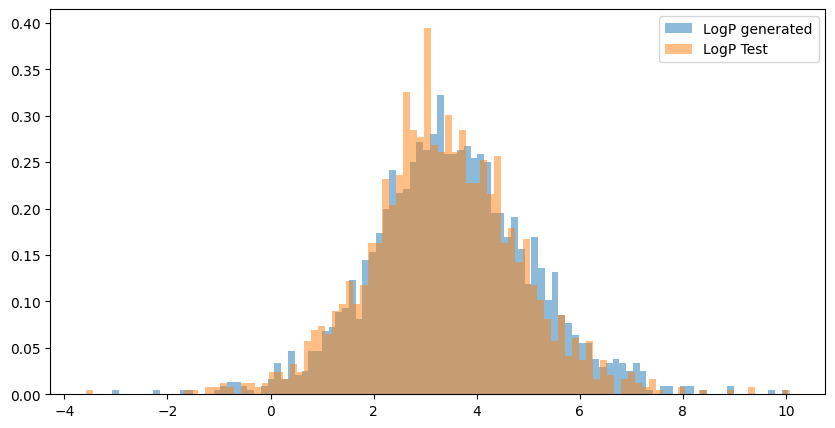

In [28]:
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_dir, 'logp_distribution.png'))

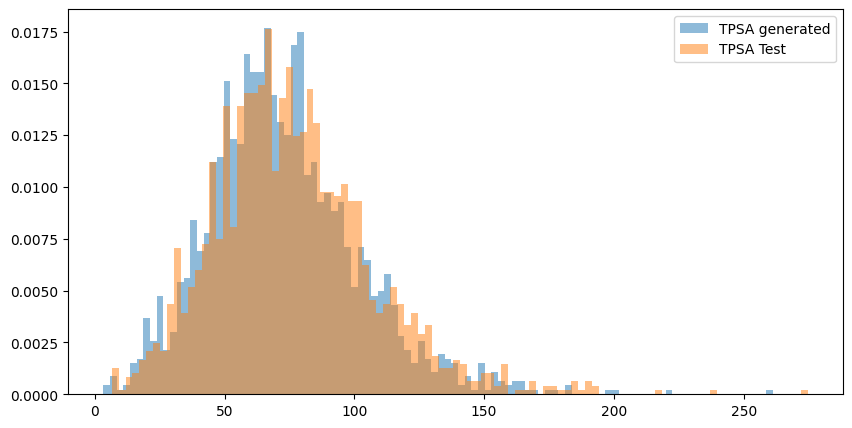

In [29]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_dir, 'tpsa_distribution.png'))

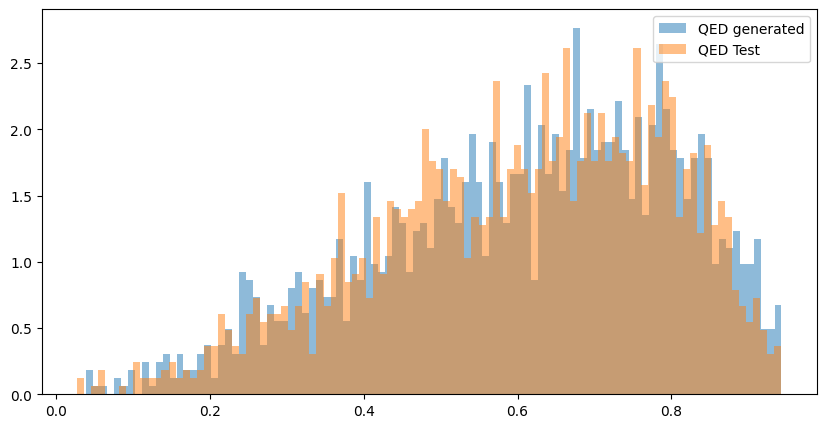

In [30]:
plt.figure(figsize=(10,5))
plt.hist(qeds, bins=100, density=True, alpha=0.5, label='QED generated')
plt.hist(qed_scaler.inverse_transform(og_qeds.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='QED Test')
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_dir, 'qed_distribution.png'))

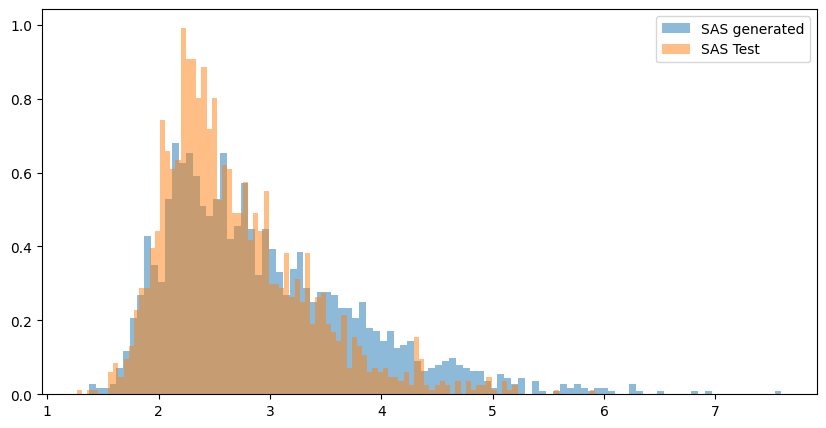

In [31]:
plt.figure(figsize=(10,5))
plt.hist(sas, bins=100, density=True, alpha=0.5, label='SAS generated')
plt.hist(sas_scaler.inverse_transform(og_sas.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='SAS Test')
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_dir, 'sas_distribution.png'))

In [32]:
stats = pd.DataFrame({
                      "SAS_pred":sas, 
                      "QED_pred":qeds, 
                      "LogP_pred":logps, 
                    #   "molwt_pred":molwt, 
                      "TPSA_pred":tpsas})
stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
stats['QED_og'] = qed_scaler.inverse_transform(og_qeds.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

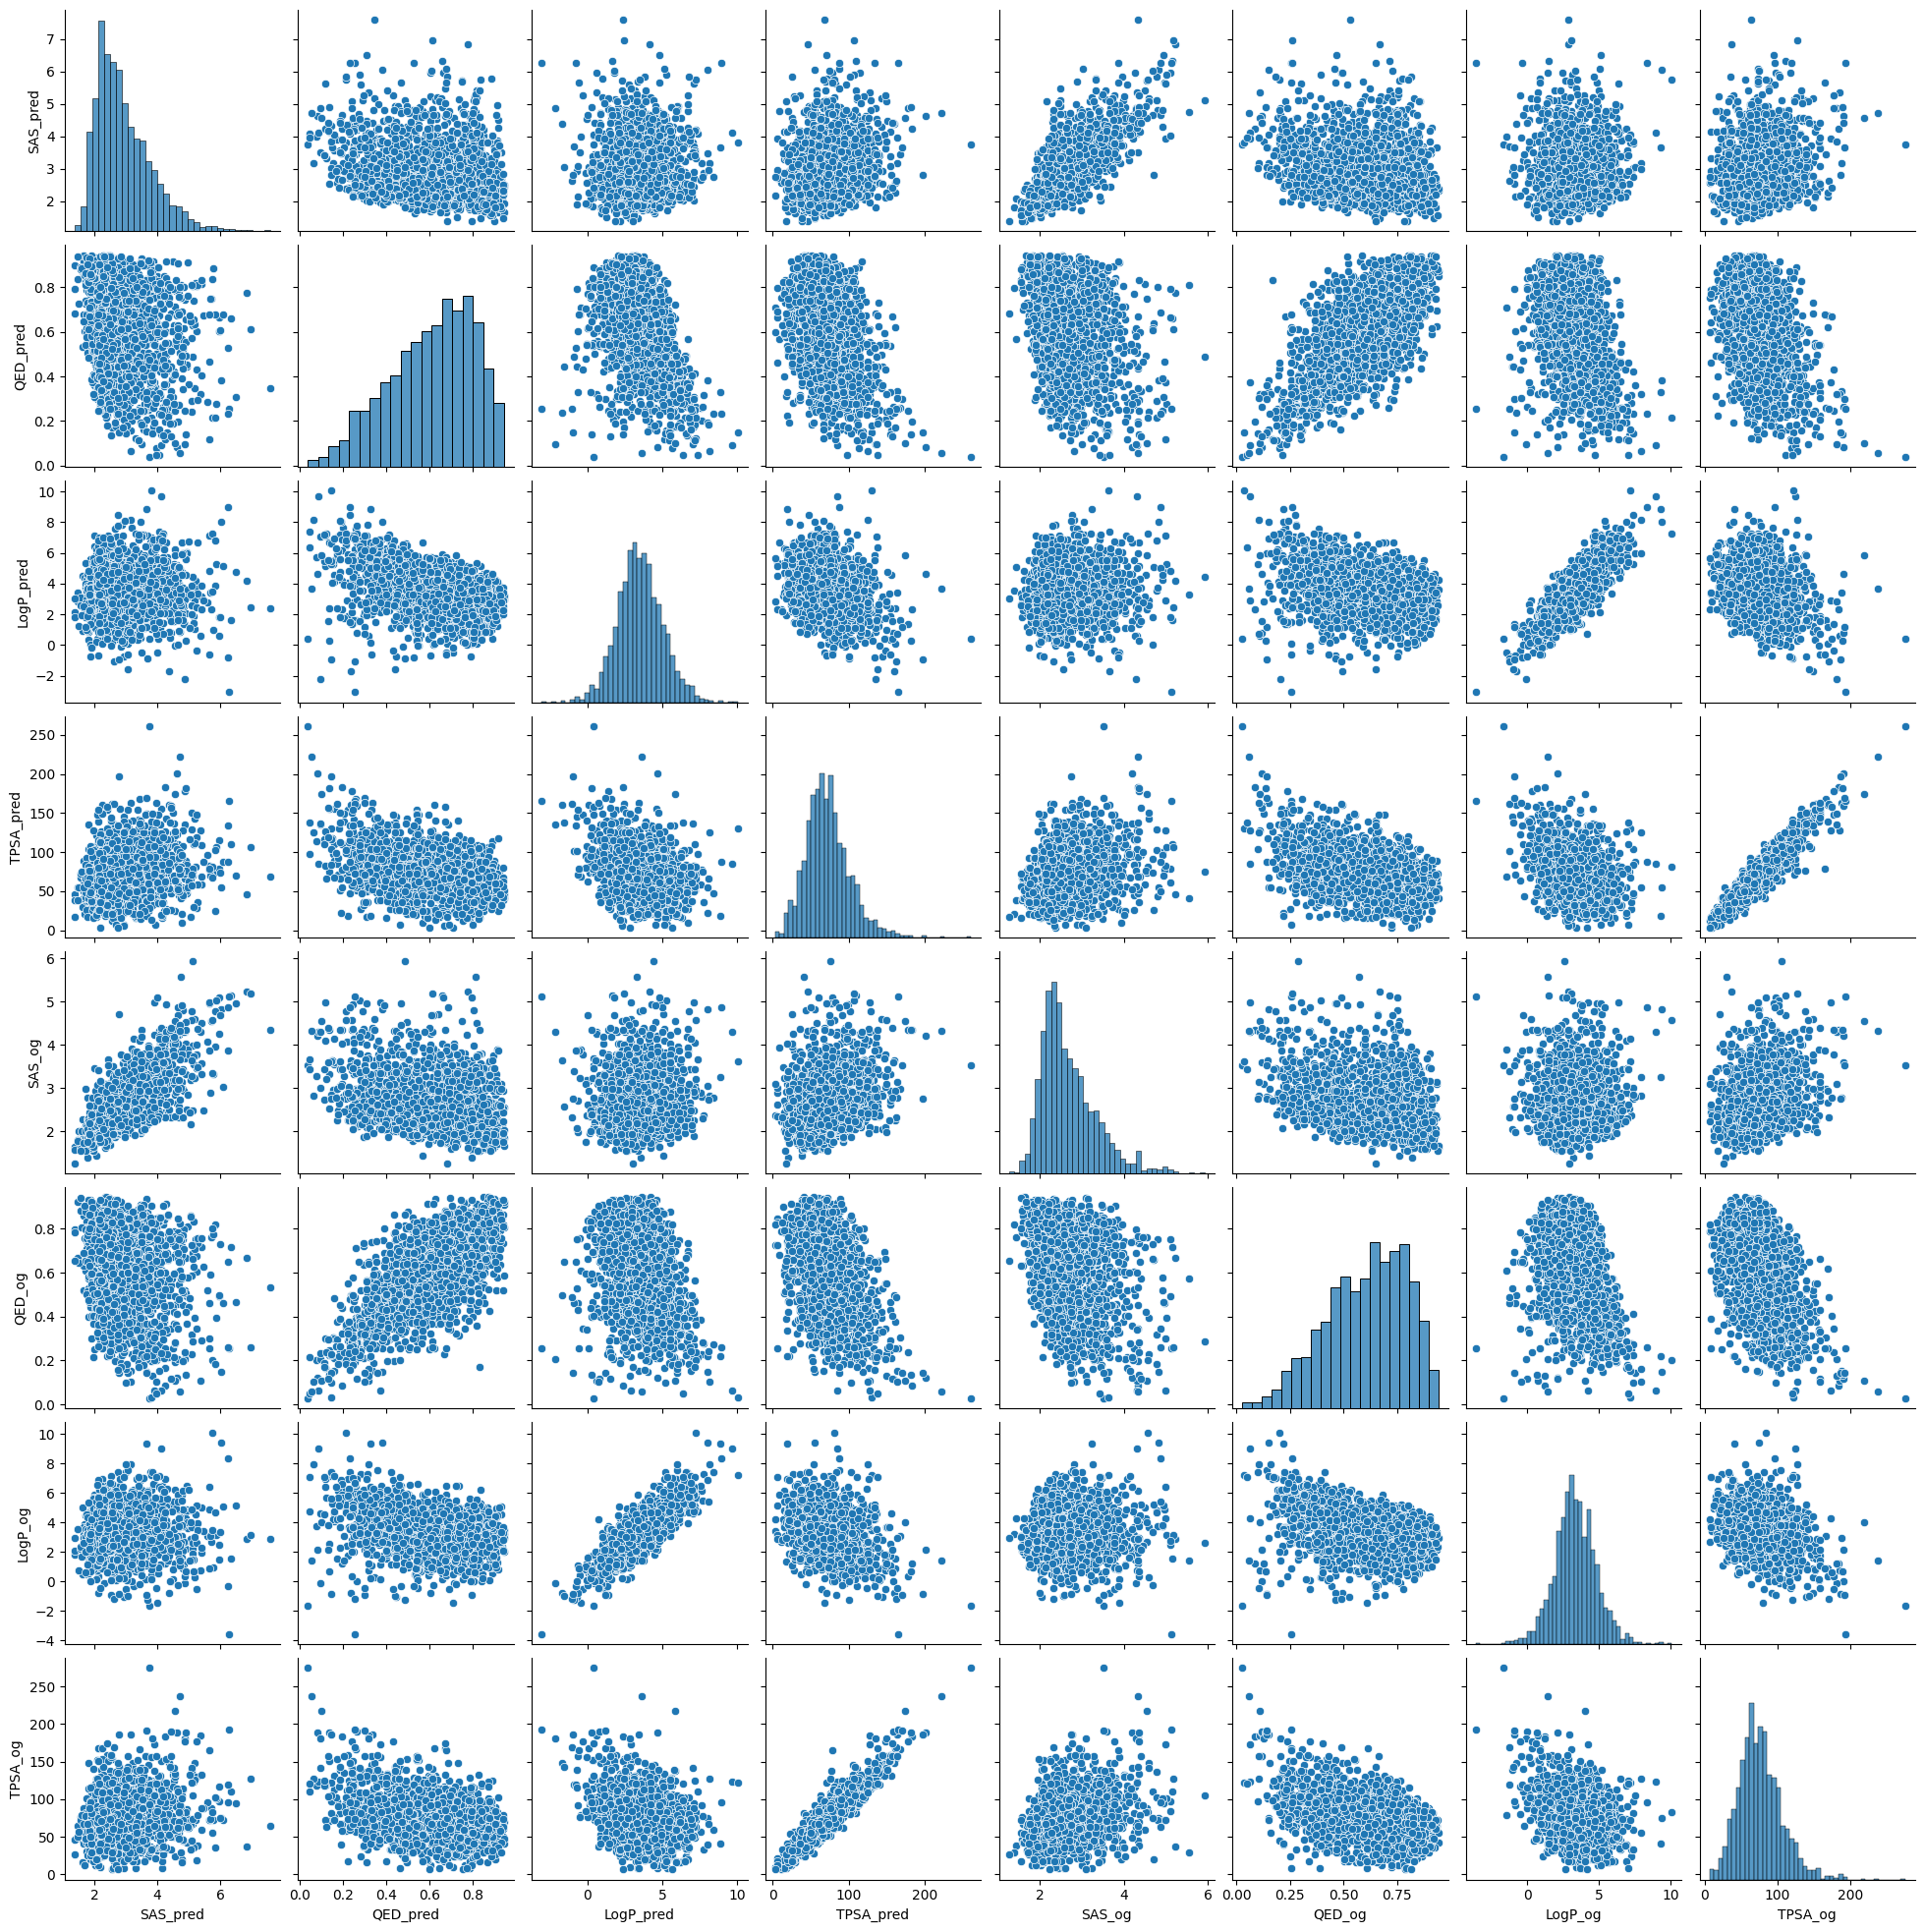

In [33]:
import seaborn as sns
pp=sns.pairplot(stats)
pp.savefig(os.path.join(results_dir, 'pairplot.png'))

In [34]:
target_props = {}
target_props['affinity'] = [-9, -8, -7]
target_props['logp'] = [2, 5]
# target_props['molwt'] = [280, 320]
target_props['qed'] = [0.3, 0.8]
target_props['tpsa'] = [40,100]
target_props['sas'] = [2, 4]

In [35]:
queries = []
property_vectors = []
for a in target_props['affinity']:
    for b in target_props['logp']:
        for c in target_props['qed']:
            for d in target_props['sas']:
                for e in target_props['tpsa']:

                    key = str(a)+'-'+str(b)+'-' + str(c)+'-' + str(d)+ '-' + str(e)
                    t = torch.Tensor([
                        affinity_scaler.transform([[a]]).flatten()[0],
                        logp_scaler.transform([[b]]).flatten()[0],
                        qed_scaler.transform([[c]]).flatten()[0],
                        sas_scaler.transform([[d]]).flatten()[0],
                        tpsas_scaler.transform([[e]]).flatten()[0]
                        ])
                    queries.append(key)
                    property_vectors.append(t)
property_vectors = torch.stack(property_vectors, dim=0)

In [36]:
sampler = Sampler(model, smiles_vocab)

In [37]:
results = {}
count = 0
for key, v in zip(queries, property_vectors):
    print(key, v)

    p = v.repeat(config['batch_size'], 1)
    samples = sampler.sample(p, greedy=False)
    if key in results:
        print("duplicate key", key)
    qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
    # results[key] = [logps, tpsas, qeds, samples]
    results[key] = [logps, qeds, sas, tpsas, samples]

    count += 1

-9-2-0.3-2-40 tensor([0.4694, 0.4638, 0.3106, 0.1468, 0.0805])
-9-2-0.3-2-100 tensor([0.4694, 0.4638, 0.3106, 0.1468, 0.2011])
-9-2-0.3-4-40 tensor([0.4694, 0.4638, 0.3106, 0.4405, 0.0805])
-9-2-0.3-4-100 tensor([0.4694, 0.4638, 0.3106, 0.4405, 0.2011])
-9-2-0.8-2-40 tensor([0.4694, 0.4638, 0.8424, 0.1468, 0.0805])
-9-2-0.8-2-100 tensor([0.4694, 0.4638, 0.8424, 0.1468, 0.2011])
-9-2-0.8-4-40 tensor([0.4694, 0.4638, 0.8424, 0.4405, 0.0805])
-9-2-0.8-4-100 tensor([0.4694, 0.4638, 0.8424, 0.4405, 0.2011])
-9-5-0.3-2-40 tensor([0.4694, 0.5918, 0.3106, 0.1468, 0.0805])
-9-5-0.3-2-100 tensor([0.4694, 0.5918, 0.3106, 0.1468, 0.2011])
-9-5-0.3-4-40 tensor([0.4694, 0.5918, 0.3106, 0.4405, 0.0805])
-9-5-0.3-4-100 tensor([0.4694, 0.5918, 0.3106, 0.4405, 0.2011])
-9-5-0.8-2-40 tensor([0.4694, 0.5918, 0.8424, 0.1468, 0.0805])
-9-5-0.8-2-100 tensor([0.4694, 0.5918, 0.8424, 0.1468, 0.2011])
-9-5-0.8-4-40 tensor([0.4694, 0.5918, 0.8424, 0.4405, 0.0805])
-9-5-0.8-4-100 tensor([0.4694, 0.5918, 0.8424, 0

In [38]:
import pickle
import pandas as pd
# dump results dictionary into a pickle file

with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [39]:
data = []
columns = ['Target LogP', 'Target QED', 'Target SAS', 'Target TPSA', 'Predicted LogP','Predicted QED' ,'Predicted SAS','Predicted TPSA', 'key']
for key in results:
    keys = key.split('-')
    affinity = keys[1]
    logp = keys[2]
    qed = keys[3]
    sas = keys[4]
    tpsa = keys[5]
    for i in range(len(results[key][0])):
        data.append([logp, qed, sas, tpsa, results[key][0][i], results[key][1][i], results[key][2][i], results[key][3][i], key])

<Axes: xlabel='Predicted TPSA', ylabel='Density'>

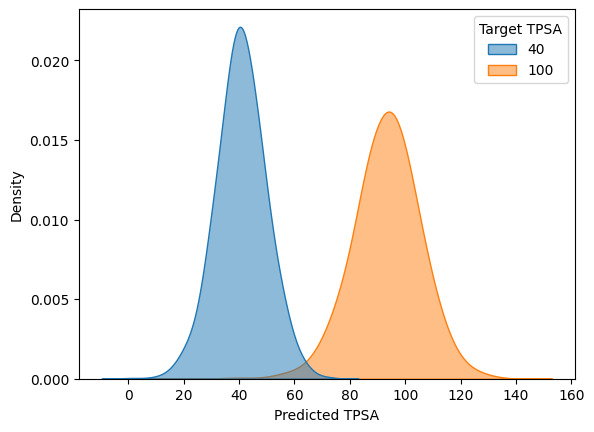

In [40]:
data_df = pd.DataFrame(data, columns=columns)
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)

AttributeError: 'Axes' object has no attribute 'savefig'

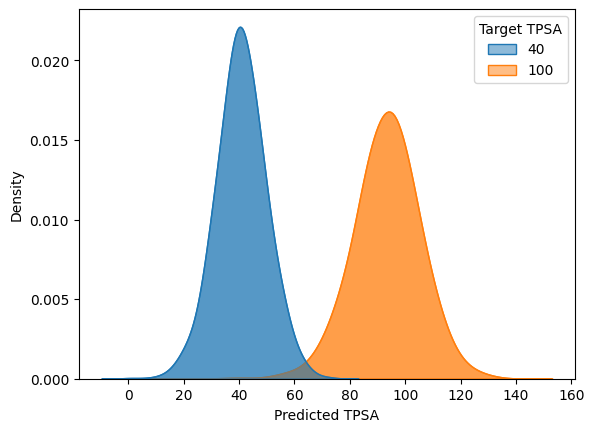

In [41]:
data_df = pd.DataFrame(data, columns=columns)
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)
a=sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)
a.savefig(os.path.join(results_dir, 'tpsa_targeted.png'))

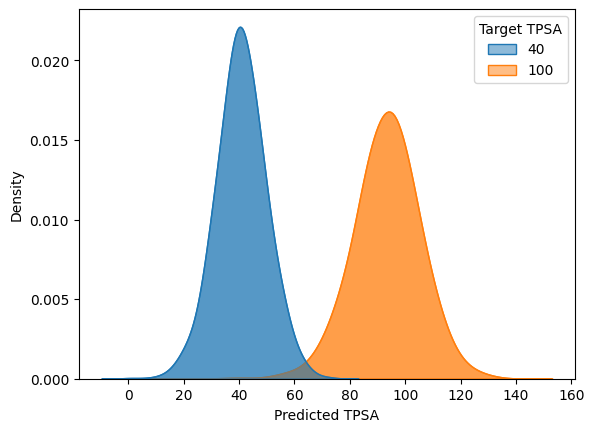

In [42]:
data_df = pd.DataFrame(data, columns=columns)
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)
a=sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)
(a.get_figure()).savefig(os.path.join(results_dir, 'tpsa_targeted.png'))

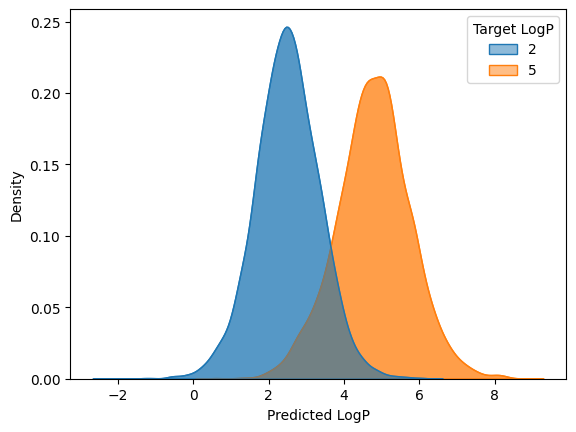

In [43]:
sns.kdeplot(data=data_df, x="Predicted LogP",hue="Target LogP", fill=True,alpha=.5, linewidth=1)
a=sns.kdeplot(data=data_df, x="Predicted LogP",hue="Target LogP", fill=True,alpha=.5, linewidth=1)
(a.get_figure()).savefig(os.path.join(results_dir, 'logp_targeted.png'))

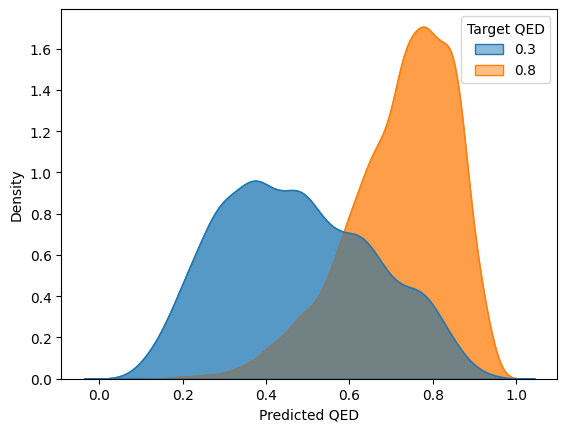

In [44]:
sns.kdeplot(data=data_df, x="Predicted QED",hue="Target QED", fill=True,alpha=.5, linewidth=1)
a=sns.kdeplot(data=data_df, x="Predicted QED",hue="Target QED", fill=True,alpha=.5, linewidth=1)
(a.get_figure()).savefig(os.path.join(results_dir, 'qed_targeted.png'))

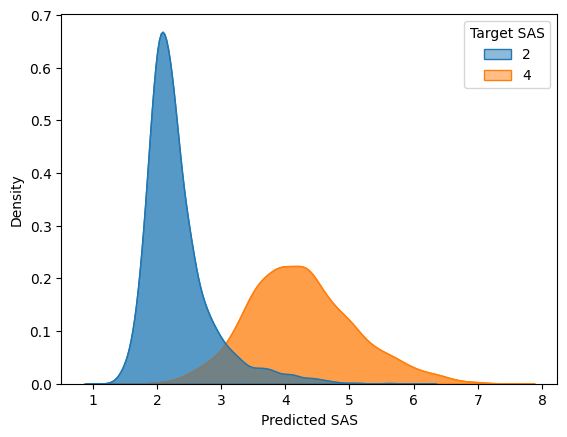

In [45]:
sns.kdeplot(data=data_df, x="Predicted SAS",hue="Target SAS", fill=True,alpha=.5, linewidth=1)
a=sns.kdeplot(data=data_df, x="Predicted SAS",hue="Target SAS", fill=True,alpha=.5, linewidth=1)
(a.get_figure()).savefig(os.path.join(results_dir, 'sas_targeted.png'))

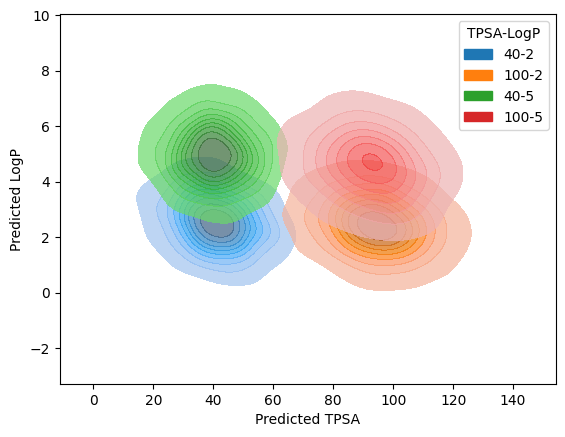

In [46]:
data_df['TPSA-LogP'] = data_df['Target TPSA'] +'-' +data_df['Target LogP']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted LogP", hue="TPSA-LogP", fill=True, alpha=0.7, bw_adjust=1.5)
(ax.get_figure()).savefig(os.path.join(results_dir, 'tpsa_logp_targeted.png'))

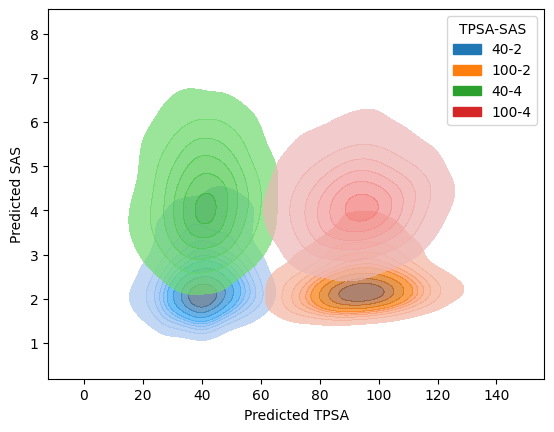

In [47]:
data_df['TPSA-SAS'] = data_df['Target TPSA'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted SAS", hue="TPSA-SAS", fill=True, alpha=0.7, bw_adjust=1.5)
(ax.get_figure()).savefig(os.path.join(results_dir, 'tpsa_sas_targeted.png'))

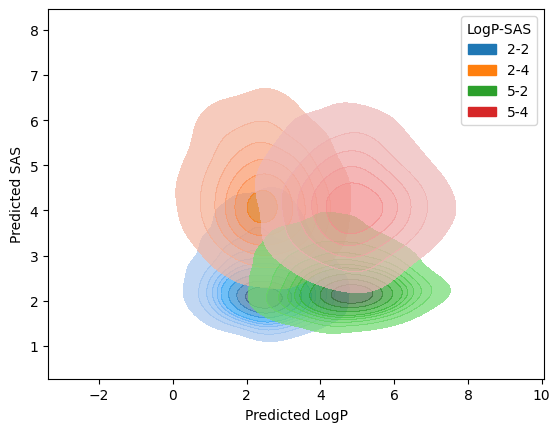

In [48]:
data_df['LogP-SAS'] = data_df['Target LogP'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted LogP", y="Predicted SAS", hue="LogP-SAS", fill=True, alpha=0.7, bw_adjust=1.5)
(ax.get_figure()).savefig(os.path.join(results_dir, 'logp_sas_targeted.png'))